In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.utils import algorithm_globals
from qiskit.circuit import ParameterVector

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

algorithm_globals.random_seed = 42

from qiskit import transpile
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2

In [3]:
objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    global objective_func_vals
    
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Engineer a sample dataset with 2 features and 20 samples 
It is seperated at the `feature2 = -feature1` line

In [4]:
num_features = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_features]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}

y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

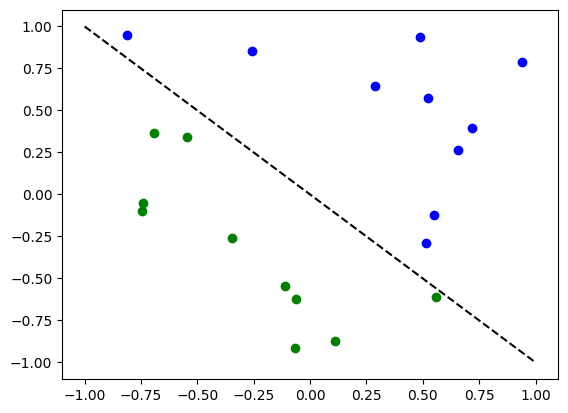

In [5]:
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")

plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

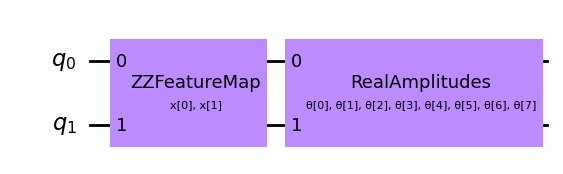

In [6]:
qc = QNNCircuit(num_qubits=2)
qc.draw("mpl", style="clifford")

In [7]:
estimator_qnn = EstimatorQNN(circuit=qc)
print(f'Weights: {estimator_qnn.weight_params}')
print(f'No. of weights: {estimator_qnn.num_weights}')

Weights: [ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7])]
No. of weights: 8


/tmp/ipykernel_4644/569363638.py:1: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator_qnn = EstimatorQNN(circuit=qc)
/tmp/ipykernel_4644/569363638.py:1: UserWarning: No number of qubits was not specified (None) and was retrieved from `circuit` (2). If `circuit` is transpiled, this may cause unstable behaviour.
  estimator_qnn = EstimatorQNN(circuit=qc)


In [8]:
sim = AerSimulator()

In [14]:
estimator_qnn.forward(X[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))

array([[-0.10839094]])

In [15]:
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
)

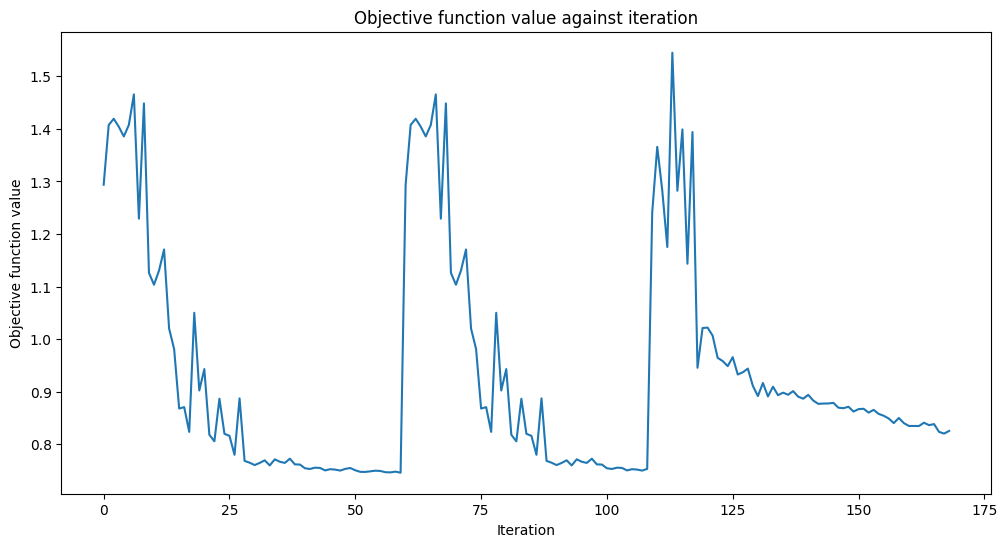

In [16]:
plt.rcParams["figure.figsize"] = (12, 6)
estimator_classifier.fit(X, y)
plt.rcParams["figure.figsize"] = (6, 4)

In [17]:
estimator_classifier.score(X, y)

0.7

In [18]:
y_predict = estimator_classifier.predict(X)

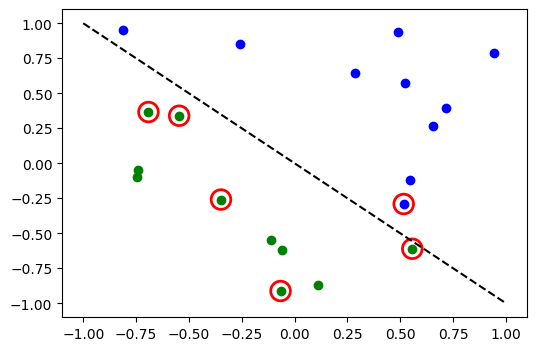

In [19]:
# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [20]:
estimator_classifier.weights

array([ 1.17109369,  0.26821639,  1.44924579, -1.25387309, -0.52966306,
       -0.29778853,  0.97833077,  0.379664  ])

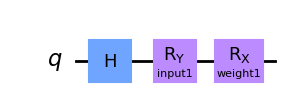

In [21]:
params1 = [Parameter("input1"), Parameter("weight1")]
qc1 = QuantumCircuit(1)
qc1.h(0)
qc1.ry(params1[0], 0)
qc1.rx(params1[1], 0)
qc1.draw("mpl", style="clifford")

In [22]:
observable1 = SparsePauliOp.from_list([("Y" * qc1.num_qubits, 1)])
observable1

SparsePauliOp(['Y'],
              coeffs=[1.+0.j])

In [24]:
estimator_qnn = EstimatorQNN(
    circuit=qc1, observables=observable1, input_params=[params1[0]], weight_params=[params1[1]]
)
estimator_qnn


/tmp/ipykernel_4644/1736127978.py:1: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator_qnn = EstimatorQNN(
/tmp/ipykernel_4644/1736127978.py:1: UserWarning: No number of qubits was not specified (None) and was retrieved from `circuit` (1). If `circuit` is transpiled, this may cause unstable behaviour.
  estimator_qnn = EstimatorQNN(


In [ ]:
inputs2 = ParameterVector("input", 2)
weights2 = ParameterVector("weight", 4)
print(f"input parameters: {[str(item) for item in inputs2.params]}")
print(f"weight parameters: {[str(item) for item in weights2.params]}")

qc2 = QuantumCircuit(2)
qc2.ry(inputs2[0], 0)
qc2.ry(inputs2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[0], 0)
qc2.ry(weights2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[2], 0)
qc2.ry(weights2[3], 1)

qc2.draw("mpl", style="clifford")